In [1]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import math
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class TimeEmbedding(nn.Module):
    """
    T:时间步数量
    d_model:正余弦embedding长度
    dim:TimeEmbedding 长度
    """
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / torch.Tensor([d_model]) * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        
        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb

    
    
class DownSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,3,2,1)
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x,t_emb):
        return self.main(x)
    

class UpSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,3,1,1)
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x,t_emb):
        _,_,H,W=x.shape
        x=F.interpolate(
            x,scale_factor=2,mode='nearest'
        )
        return self.main(x)

    
class AttnBlock(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.group_norm=nn.GroupNorm(32,in_c)
        self.proj_q=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_k=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_v=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_out=nn.Conv2d(in_c,in_c,1,1,0)
        self.initialize()
    def initialize(self):
        for layer in [self.proj_q,self.proj_k,self.proj_v,self.proj_out]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.proj_out.weight,gain=1e-5)
    def forward(self,x):
        B,C,H,W=x.shape
        h=self.group_norm(x)
        q=self.proj_q(x)
        k=self.proj_k(x)
        v=self.proj_v(x)
        q=q.permute(0,2,3,1).view(B,H*W,C)
        k=k.view(B,C,H*W)
        w=torch.bmm(q,k)*(int(C)**(-0.5))
        w=F.softmax(w,dim=-1)##(B,H*W,H*W)
        v=v.permute(0,2,3,1).view(B,H*W,C)
        h=torch.bmm(w,v)
        h=h.view(B,H,W,C).permute(0,3,1,2)
        h=self.proj_out(h)
        return x+h


class ResBlock(nn.Module):
    def __init__(self,in_c,out_c,t_dim,dropout,attn=False):
        super().__init__()
        ## block1:调整通道数
        self.block1=nn.Sequential(
            nn.GroupNorm(32,in_c),
            nn.GELU(),
            nn.Conv2d(in_c,out_c,3,1,1)
        )
        
        ## proj_t对加噪步数嵌入加一个线性映射,使得和通道数一样
        self.proj_t=nn.Sequential(
            nn.GELU(),
            nn.Linear(t_dim,out_c)
        )
        
        ## block2:综合步数信息后再进行一个卷积操作
        self.block2=nn.Sequential(
            nn.GroupNorm(32,out_c),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_c,out_c,3,1,1)
        )
        
        if in_c!=out_c:
            self.short_cut=nn.Conv2d(in_c,out_c,1,1,0)
        else:
            self.short_cut=nn.Identity()
        
        if attn:
            self.attn=AttnBlock(out_c)
        else:
            self.attn=nn.Identity()
        self.initialize()
    def initialize(self):
        for module in self.modules():
            if isinstance(module,(nn.Conv2d,nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
        nn.init.xavier_uniform_(self.block2[-1].weight,gain=1e-5)
    def forward(self,x,t_emb):
        h=self.block1(x)
        t_emb=self.proj_t(t_emb)
        h+=t_emb[:,:,None,None]
        h=self.block2(h)
        h=h+self.short_cut(x)
        return self.attn(h)


class UNet(nn.Module):
    def __init__(self,T,c=128,c_mul=[1,2,2,2],attn_list=[1],num_res_block=2,dropout=0.1):
        """
        attn_list:哪些层要使用注意力机制
        """
        super().__init__()
        t_dim=c*4
        self.time_embedding=TimeEmbedding(T,c,t_dim)
        self.head=nn.Conv2d(1,c,3,1,1)##增加通道数
        self.down_blocks=nn.ModuleList()
        c_list=[c]
        now_c=c
        for i,mul in enumerate(c_mul):
            out_c=c*mul
            for _ in range(num_res_block):
                self.down_blocks.append(
                    ResBlock(now_c,out_c,t_dim,dropout,attn=(i in attn_list))
                )
                now_c=out_c
                c_list.append(now_c)
            if i!=len(c_mul)-1:
                self.down_blocks.append(DownSample(now_c))
                c_list.append(now_c)
        
        self.middle_blocks=nn.ModuleList([
            ResBlock(now_c,now_c,t_dim,dropout,attn=True),
            ResBlock(now_c,now_c,t_dim,dropout,attn=False)
        ])
        
        self.up_blocks=nn.ModuleList()
        for i,mul in reversed(list(enumerate(c_mul))):
            out_c=c*mul
            for _ in range(num_res_block+1):
                self.up_blocks.append(
                    ResBlock(c_list.pop()+now_c,out_c,t_dim,dropout,attn=(i in attn_list))
                )
                now_c=out_c
            if i!=0:
                self.up_blocks.append(UpSample(now_c))
                
        self.tail=nn.Sequential(
            nn.GroupNorm(32,now_c),
            nn.GELU(),
            nn.Conv2d(now_c,1,3,1,1)
        )## 更改输出通道数
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)
        nn.init.xavier_uniform_(self.tail[-1].weight)
        nn.init.zeros_(self.tail[-1].bias)
    
    def forward(self,x,t):
        t_emb=self.time_embedding(t)
        h=self.head(x)
        h_list=[h]
        for layer in self.down_blocks:
            h=layer(h,t_emb)
            h_list.append(h)
        for layer in self.middle_blocks:
            h=layer(h,t_emb)
        for layer in self.up_blocks:
            if isinstance(layer,ResBlock):
                h=torch.cat([h,h_list.pop()],dim=1)
                #print(h.shape)
            h=layer(h,t_emb)
            
        h=self.tail(h)
        return h

In [93]:

class Model(nn.Module):
    def __init__(self,device,beta_1,beta_T,T,tau):
        super().__init__()
        self.device=device
        self.backbone=UNet(T)
        ## 计算累积乘积
        self.alpha_bars=torch.cumprod(1-torch.linspace(beta_1,beta_T,steps=T),dim=0).to(device)
        self.tau=tau
        self.diffusion_process=[l[0] for l in self.get_process_scheduling(reverse=False)]
        self.to(device)
    
    def loss_fn(self,x,idx=None):
        output,epsilon,alpha_bar=self.forward(x,idx=idx,get_target=True)
        loss=torch.mean(torch.square(output-epsilon))
        return loss
    
    def get_process_scheduling(self,reverse=True,type='uniform'):
        if type=='uniform':
            diffusion_scheduler=list(range(0,len(self.alpha_bars),self.tau))+[len(self.alpha_bars)-1]
        elif type=='exp':
            diffusion_scheduler=(np.linspace(0,np.sqrt(len(self.alpha_bars)*0.8),self.tau)**2)
            diffusion_scheduler=[int(s) for s in list(diffusion_scheduler)]+[len(self.alpha_bars)-1]
        if reverse:
            diffusion_process=zip(reversed(diffusion_scheduler[:-1]), reversed(diffusion_scheduler[1:]))
        else:
            diffusion_process=zip(diffusion_scheduler[1:], diffusion_scheduler[:-1])
        return diffusion_process
    def forward(self,x,idx=None,get_target=False):
        """
        如果idx==None，则为真实数据
        
        """
        if idx==None:
            ## DDIM可以只训练其中的若干个步骤
            idx=torch.LongTensor(np.random.choice(self.diffusion_process,size=(x.size(0),))).to(self.device)
            #idx=torch.randint(0,len(self.alpha_bars),size=(x.size(0),)).to(self.device)
            used_alpha_bars=self.alpha_bars[idx][:,None,None,None]
            epslion=torch.randn_like(x)
            x_tilde=epslion*(torch.sqrt(1-used_alpha_bars))+torch.sqrt(used_alpha_bars)*x
        else:
            idx=torch.Tensor([idx for _ in range(x.size(0))]).to(self.device).long()
            x_tilde=x
        output=self.backbone(x_tilde,idx)
        return (output,epslion,used_alpha_bars) if get_target else output

In [62]:
class DiffusionProcessDDIM():
    def __init__(self,beta_1,beta_T,T,diffusion_fn,device,shape,eta,tau=1,scheduling='uniform'):
        """
        diffusion_fn  : trained diffusion network
        shape         : data shape
        """
        self.betas=torch.linspace(beta_1,beta_T,steps=T)
        self.alphas=1-self.betas
        self.alpha_bars=torch.cumprod(self.alphas,dim=0).to(device)
        self.prev_alpha_bars=torch.cat([torch.Tensor([1]).to(device),self.alpha_bars[:-1]])
        
        ## 计算每个时间步的方差
        self.sigmas=torch.sqrt((1-self.prev_alpha_bars)/(1-self.alpha_bars))*torch.sqrt(1-self.alpha_bars/self.prev_alpha_bars)
        self.sigmas = torch.sqrt((1 - self.prev_alpha_bars) / (1 - self.alpha_bars)) * torch.sqrt(1 - (self.alpha_bars / self.prev_alpha_bars))
        ## 噪声比率
        self.eta=eta
        ## 加速比率
        self.tau=tau
        ## 采样模式
        self.scheduling=scheduling
        self.shape=shape
        self.device=device
        self.diffusion_fn=diffusion_fn
        
    def get_process_scheduling(self,reverse=True):
        if self.scheduling=='uniform':
            diffusion_scheduler=list(range(0,len(self.alpha_bars),self.tau))+[len(self.alpha_bars)-1]
        elif self.scheduling=='exp':
            diffusion_scheduler=(np.linspace(0,np.sqrt(len(self.alpha_bars)*0.8),self.tau)**2)
            diffusion_scheduler=[int(s) for s in list(diffusion_scheduler)]+[len(self.alpha_bars)-1]
        if reverse:
            diffusion_process=zip(reversed(diffusion_scheduler[:-1]), reversed(diffusion_scheduler[1:]))
        else:
            diffusion_process=zip(diffusion_scheduler[1:], diffusion_scheduler[:-1])
        return diffusion_process
    
    ## 反向过程
    def one_diffusion_step(self,x):
        diffusion_process=self.get_process_scheduling(reverse=True)
        for prev_idx,idx in diffusion_process:
            self.diffusion_fn.eval()
            noise=torch.zeros_like(x) if idx==0 else torch.randn_like(x)
            espilon=self.diffusion_fn(x,idx)
            sigma=self.sigmas[idx]*self.eta
            
            predicted_x0=torch.sqrt(self.alpha_bars[prev_idx])*(x-torch.sqrt(1-self.alpha_bars[idx])*espilon)/torch.sqrt(self.alpha_bars[idx])
            xt_grad=1-self.alpha_bars[prev_idx]-sigma**2
            xt_grad=torch.where(xt_grad>0,xt_grad,0)## 避免小于零
            direction_pointing_to_xt=torch.sqrt(xt_grad)*espilon
            x=predicted_x0+direction_pointing_to_xt+sigma*noise
            yield x
            
    @torch.no_grad()
    def sampling(self,sampling_num,sample=None,only_final=False):
        if sample==None:
            sample=torch.randn([sampling_num,*self.shape]).to(self.device)
        sampling_list=[]
        final=None
        for sample in self.one_diffusion_step(sample):
            final=sample
            if not only_final:
                sampling_list.append(sample)
        return final if only_final else sampling_list
            

In [105]:
def make_grid(sample, sampling_number = 64):
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255
            
    show_sample = show_sample.astype(np.uint8)
    return show_sample

def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(6, 6))
    #clear_output()
    show_sample = make_grid(sample, sampling_number)

    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

In [96]:
beta_1=1e-4
beta_T=0.02
T=500
eta = 1
tau = 5
shape=(1,32,32)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=Model(device,beta_1,beta_T,T,tau)
process=DiffusionProcessDDIM(beta_1,beta_T,T,model,device,shape,eta,tau)
optim=torch.optim.Adam(model.parameters(),lr=1e-4)

In [9]:
sampling_number = 16
only_final = True
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((shape[-2], shape[-1])),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.MNIST(root = './MNIST', train=True, download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, drop_last = True, num_workers = 0)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1897423.56it/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 340026.20it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3194084.01it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3634903.41it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Epoch 1/10:  53%|█████▎    | 499/937 [02:03<01:48,  4.04batch/s, loss=0.0151]

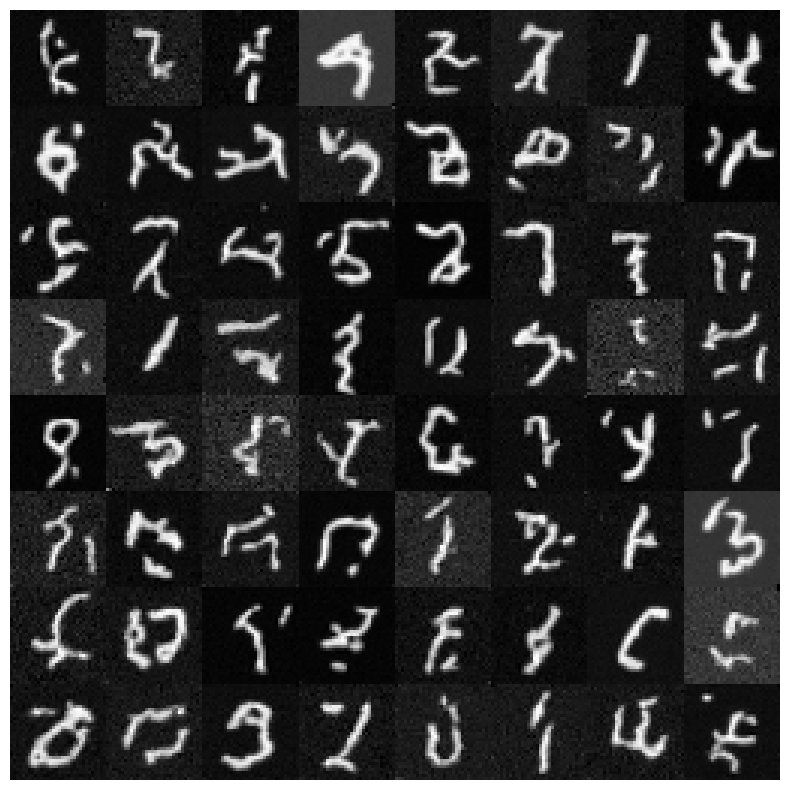

Epoch 2/10:   7%|▋         | 62/937 [00:15<03:37,  4.03batch/s, loss=0.0173]

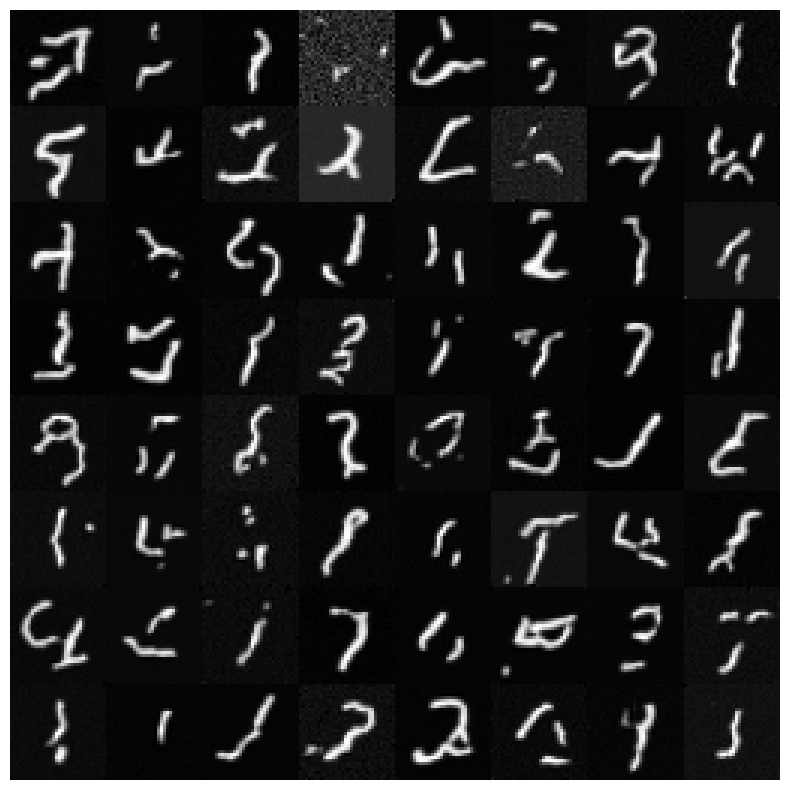

Epoch 2/10:  60%|█████▉    | 562/937 [02:27<01:32,  4.03batch/s, loss=0.0166]

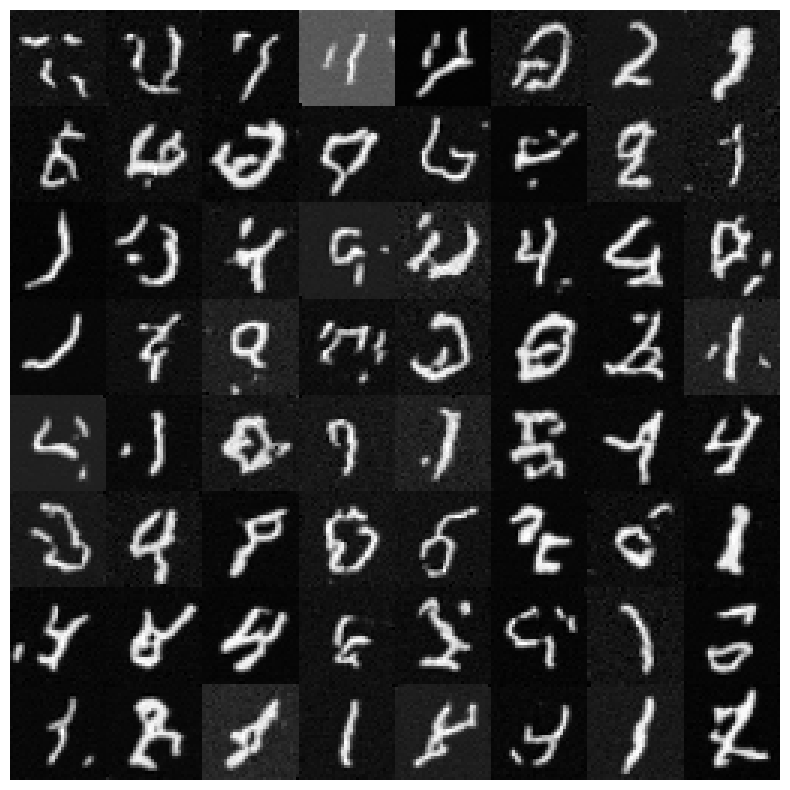

Epoch 3/10:  13%|█▎        | 125/937 [00:31<03:21,  4.02batch/s, loss=0.0189]

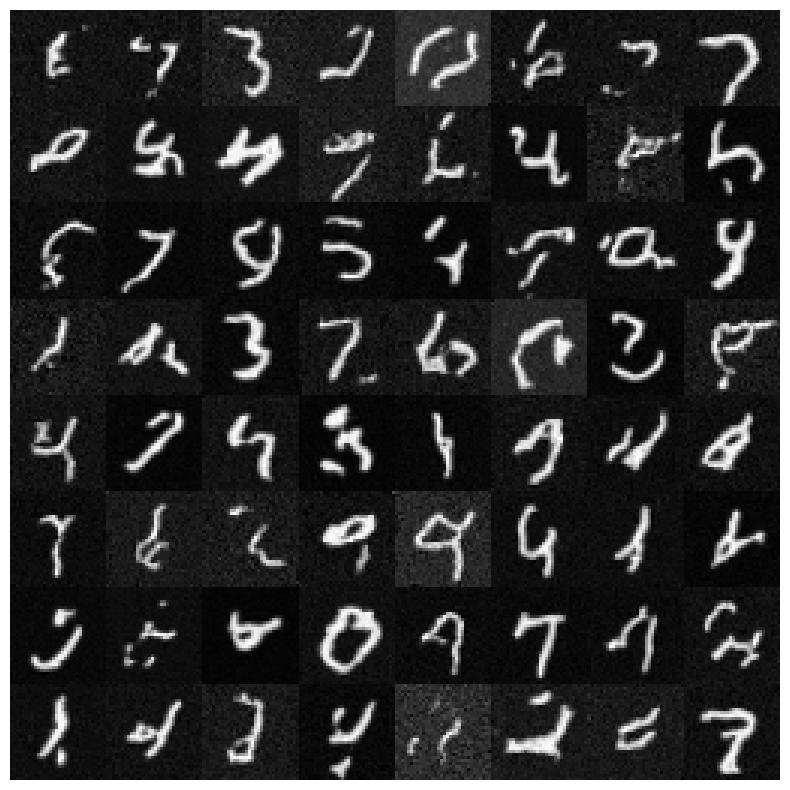

Epoch 3/10:  67%|██████▋   | 625/937 [02:43<01:17,  4.02batch/s, loss=0.0144]

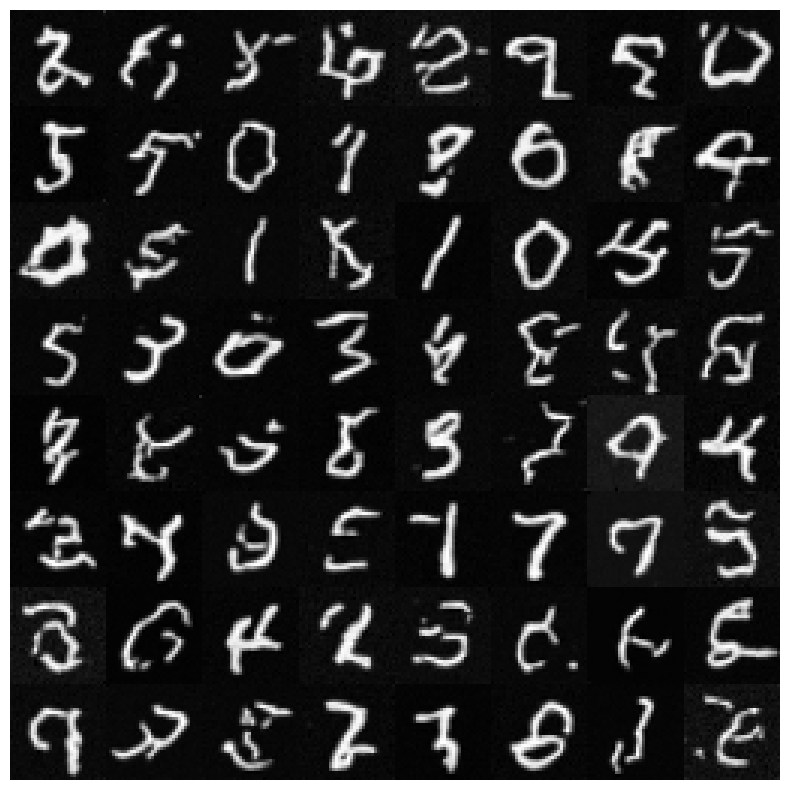

Epoch 4/10:  20%|██        | 188/937 [00:46<03:06,  4.02batch/s, loss=0.0175]

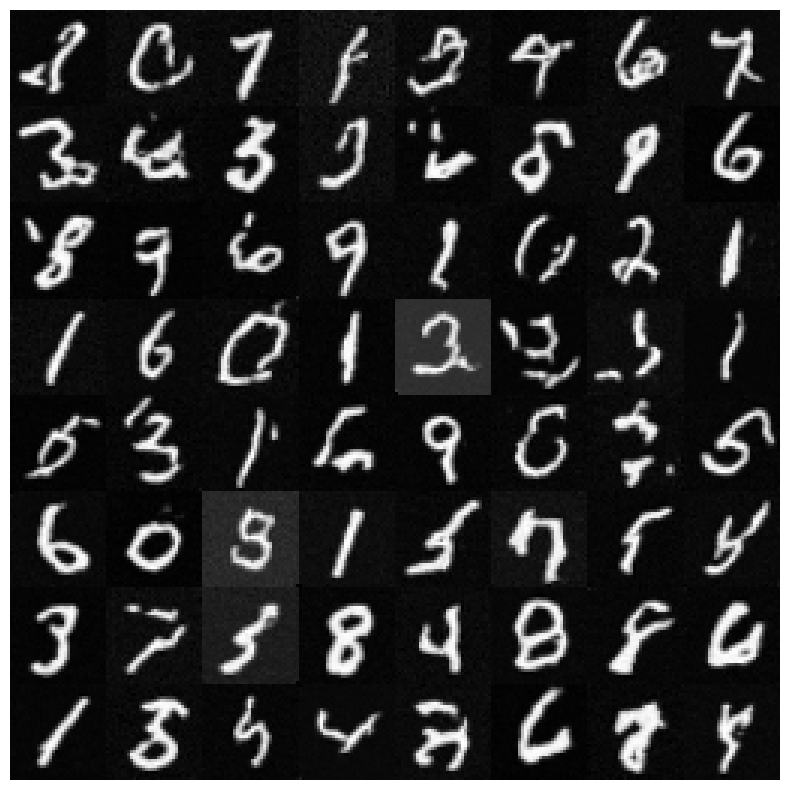

Epoch 4/10:  74%|███████▎  | 689/937 [02:59<01:01,  4.03batch/s, loss=0.0113]

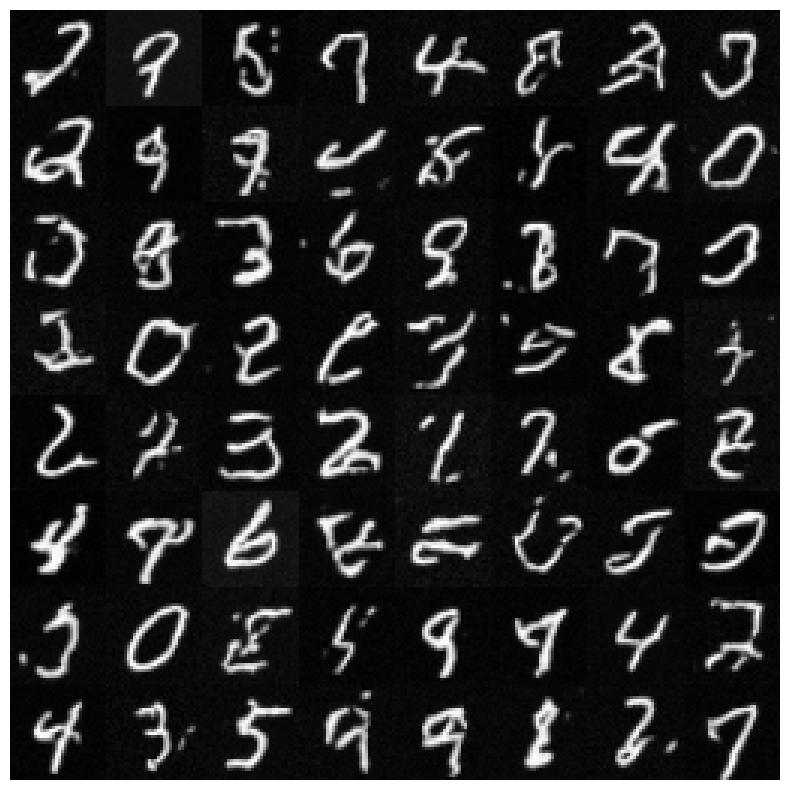

Epoch 5/10:  27%|██▋       | 251/937 [01:02<02:50,  4.02batch/s, loss=0.0169]

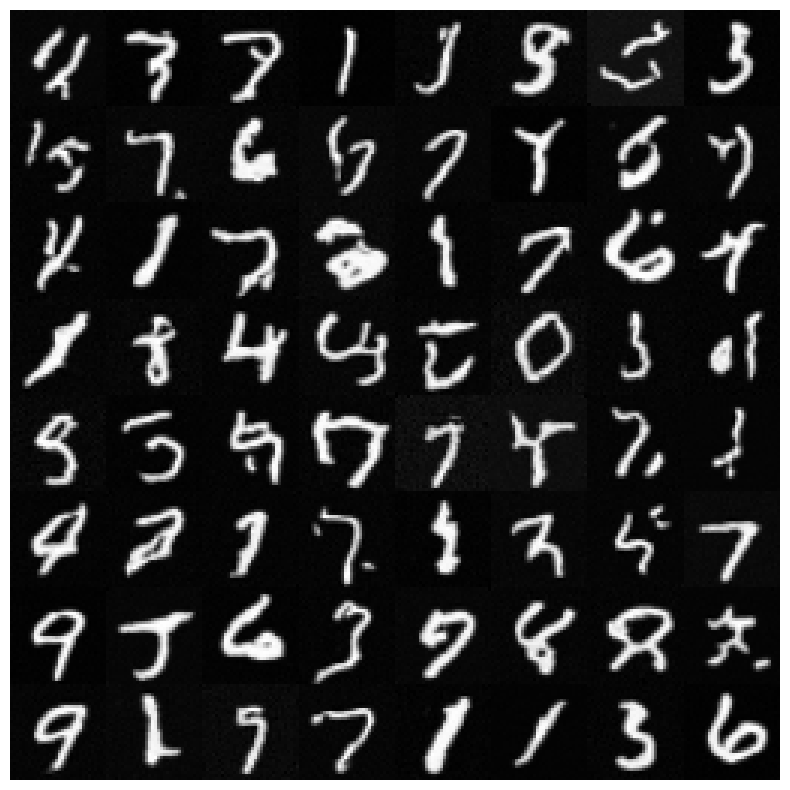

Epoch 5/10:  80%|████████  | 752/937 [03:15<00:45,  4.02batch/s, loss=0.0151]

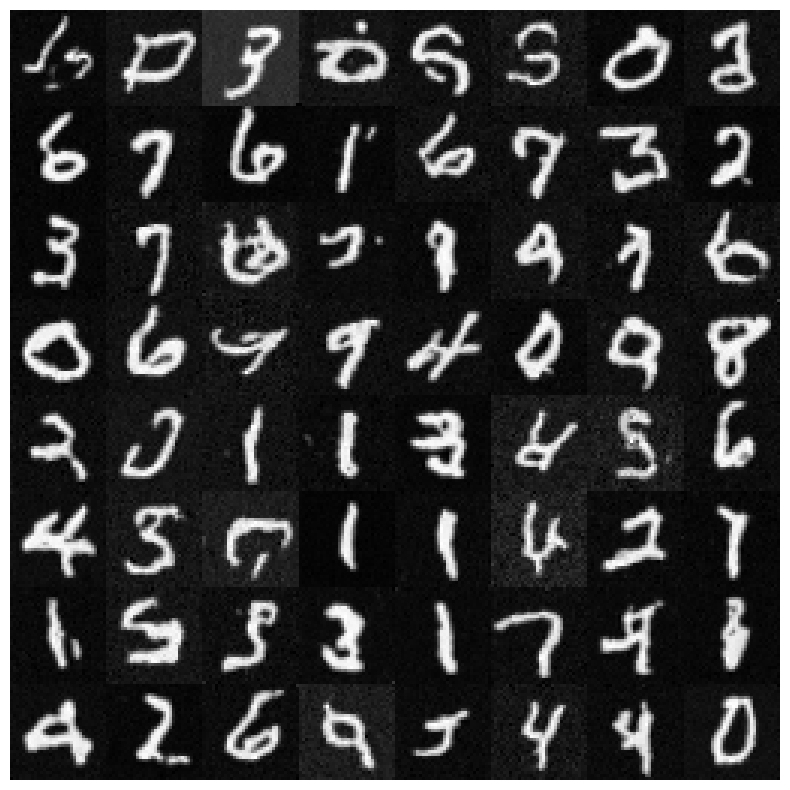

Epoch 6/10:  34%|███▎      | 314/937 [01:18<02:34,  4.02batch/s, loss=0.0178]

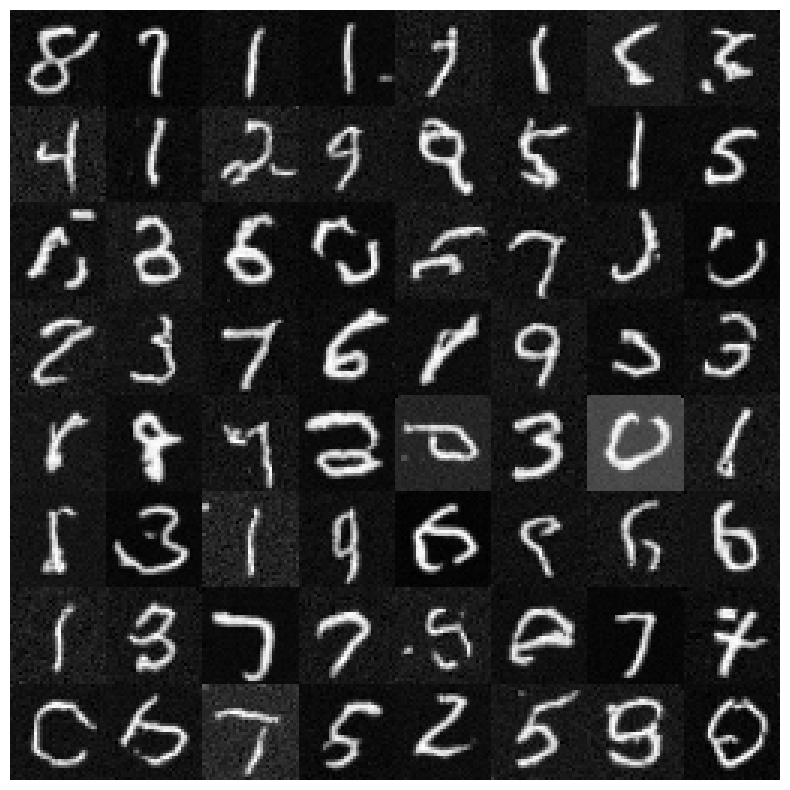

Epoch 6/10:  87%|████████▋ | 814/937 [03:30<00:30,  4.02batch/s, loss=0.0186]

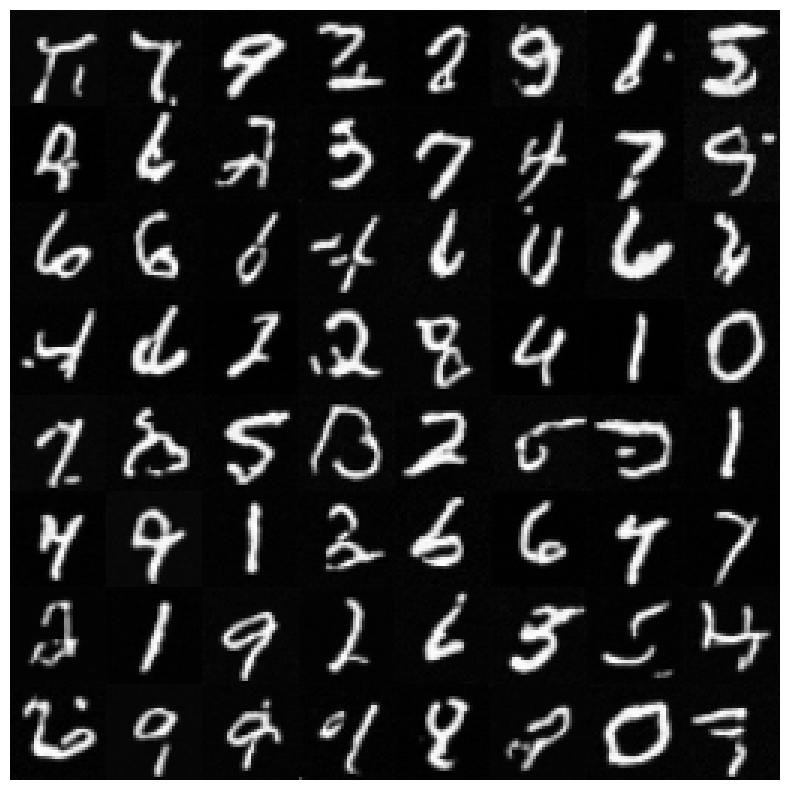

Epoch 7/10:  40%|████      | 377/937 [01:34<02:19,  4.02batch/s, loss=0.0160]

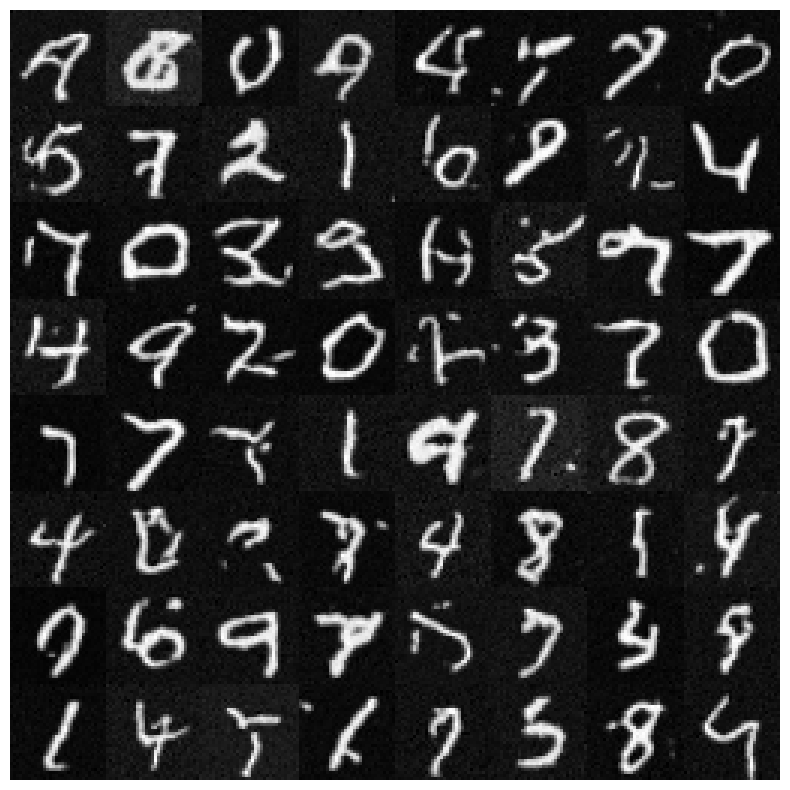

Epoch 7/10:  94%|█████████▎| 878/937 [03:53<00:14,  4.02batch/s, loss=0.0147]

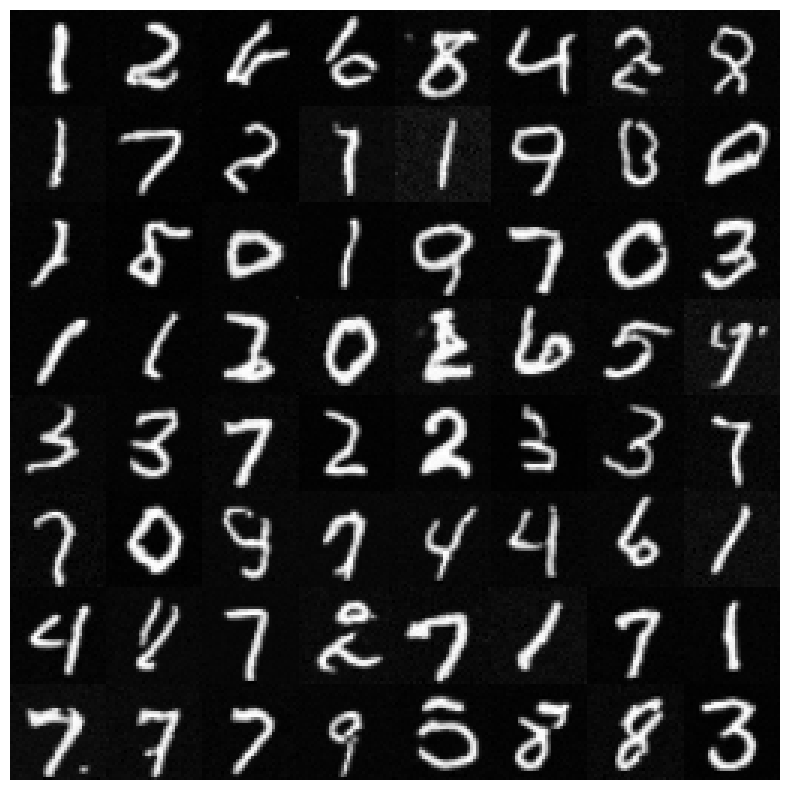

Epoch 8/10:  47%|████▋     | 440/937 [01:49<02:03,  4.03batch/s, loss=0.0173]

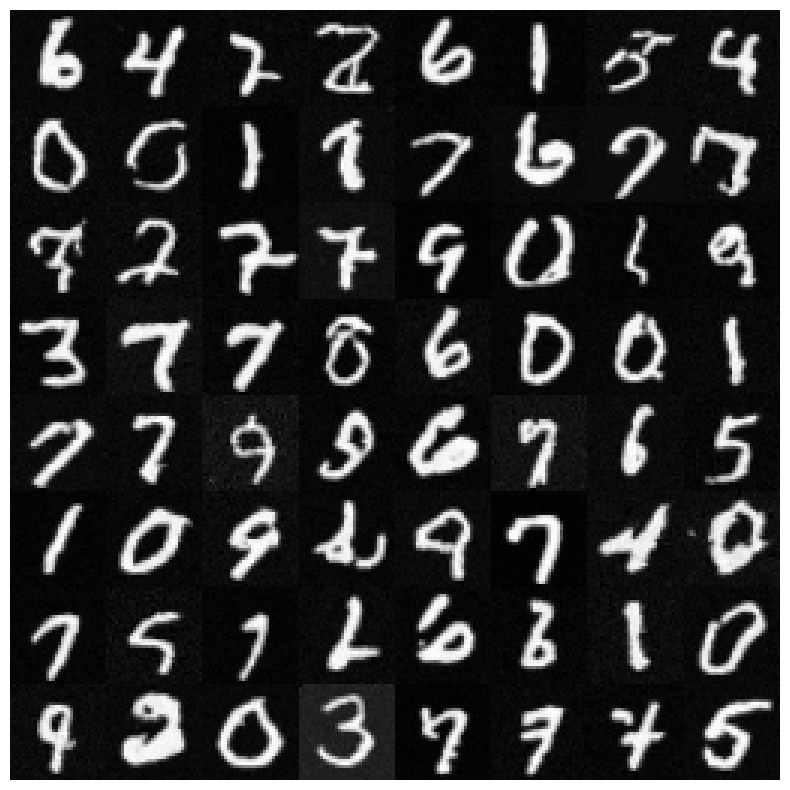

Epoch 9/10:   0%|          | 3/937 [00:00<05:08,  3.03batch/s, loss=0.0150]

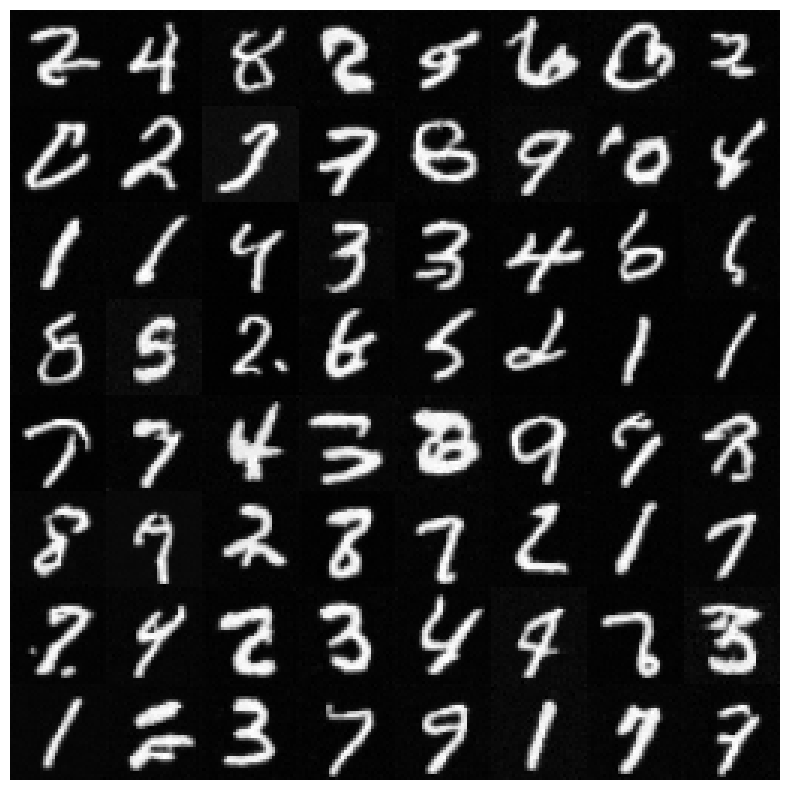

Epoch 9/10:  54%|█████▎    | 503/937 [02:13<01:47,  4.02batch/s, loss=0.0168]

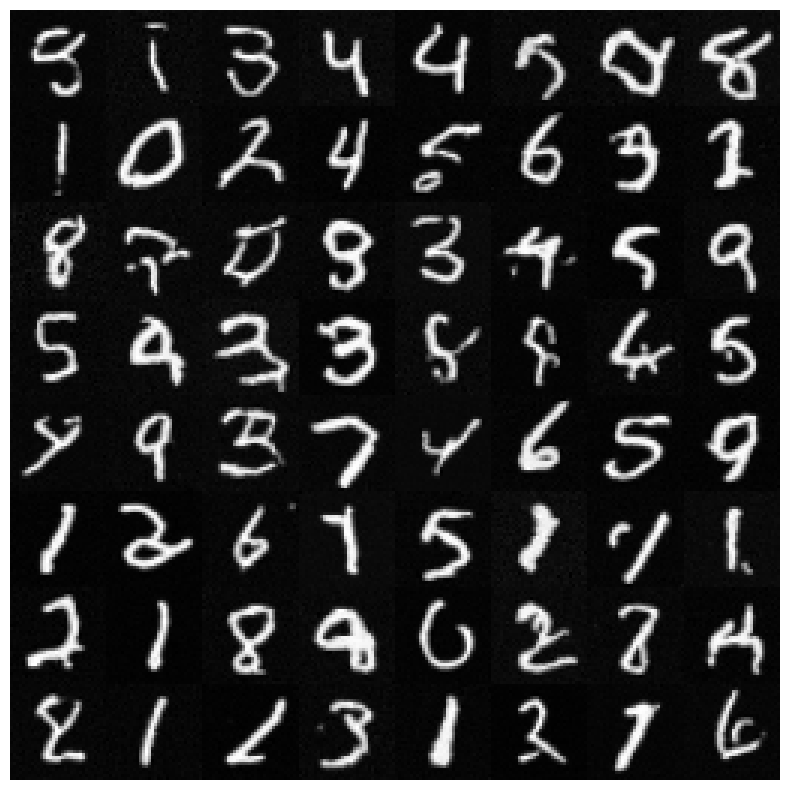

Epoch 10/10:   7%|▋         | 66/937 [00:16<03:36,  4.03batch/s, loss=0.0142]

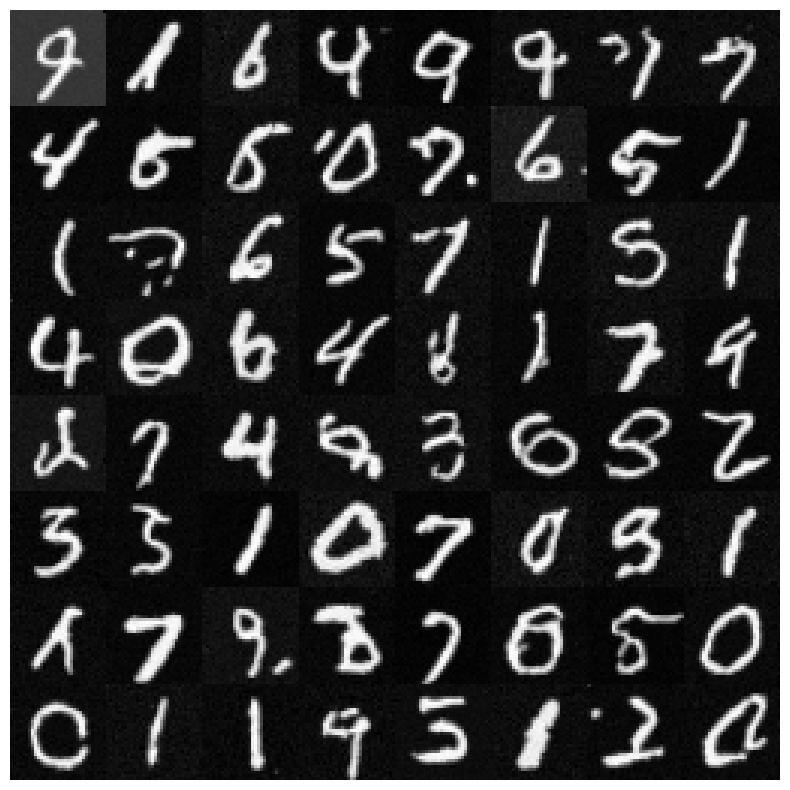

Epoch 10/10:  60%|██████    | 566/937 [02:29<01:32,  4.02batch/s, loss=0.0155]

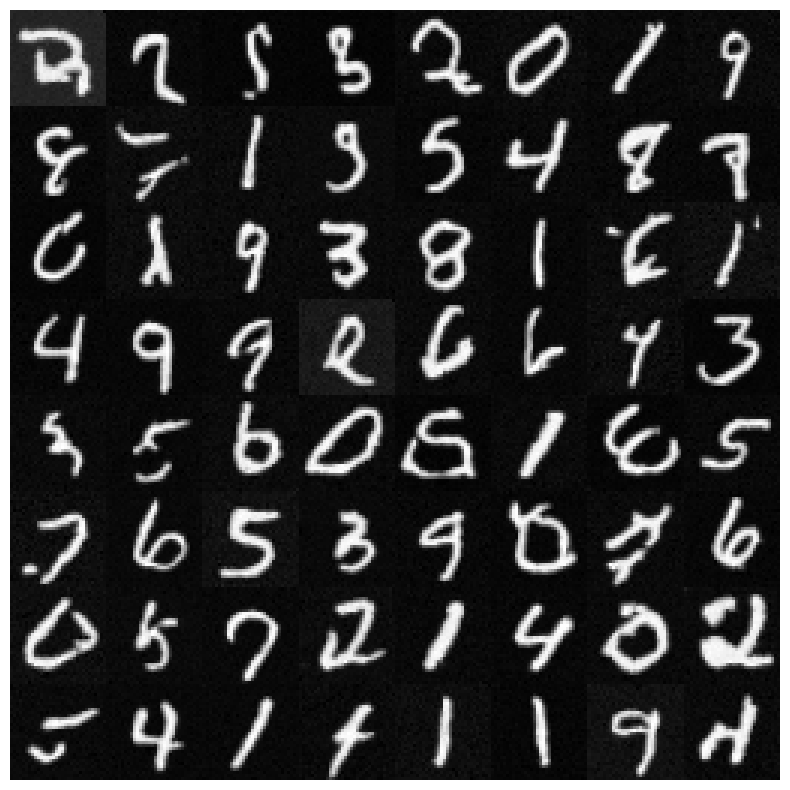

Epoch 10/10: 100%|██████████| 937/937 [04:09<00:00,  3.76batch/s, loss=0.0154]


In [101]:
from IPython.display import clear_output
from tqdm import tqdm
loss_list=[]
epochs=10
for epoch in range(epochs):
    with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch',mininterval=3) as pbar:
        for i,(imgs,labels) in enumerate(dataloader):
            imgs=imgs.to(device)
            loss = model.loss_fn(imgs)

            optim.zero_grad()
            loss.backward()
            optim.step()

            #print(
            #    "[Epoch %d/%d] [Batch %d/%d] [loss: %f]"
            #    % (epoch, epochs, i, len(dataloader), loss.item())
            #)
            loss_list.append(loss.item())

            batch_done=epoch*len(dataloader)+i
            pbar.set_postfix({'loss': f'{ loss.item():.4f}'})
            pbar.update(1)
            if (batch_done+1)%500==0:
                process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape,eta=0,tau=5)
                sample = process.sampling(sampling_number,None, only_final)
                imshow(sample, sampling_number)
        

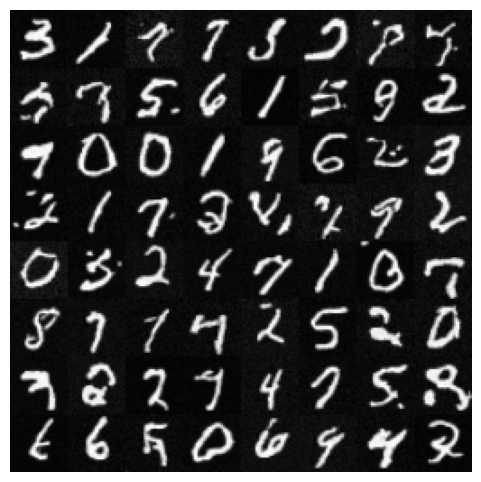

In [114]:
from IPython.display import clear_output
sampling_number = 64
only_final = True
process = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape,eta=0,tau=5)
sample = process.sampling(sampling_number,None, only_final)
imshow(sample, sampling_number)

In [107]:
sampling_number = 64
z_first = torch.randn(sampling_number, 1, 32, 32).to(device = device)

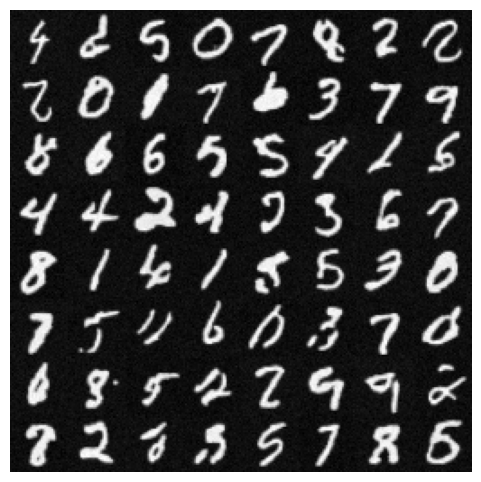

In [108]:
## DDPM
eta = 1
processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
x_DDPM = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDPM, sampling_number)

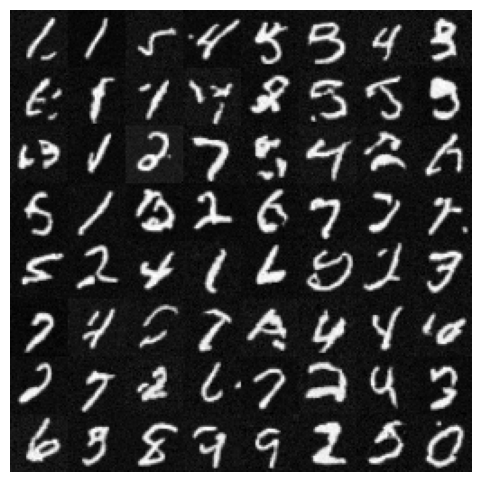

In [109]:
## DDIM
eta = 0
processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta)
x_DDIM = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM, sampling_number)

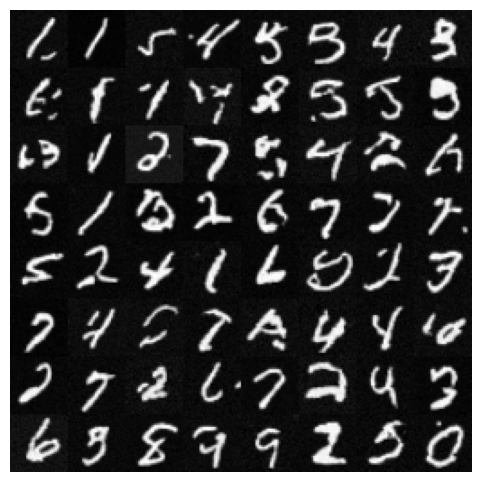

CPU times: user 8.39 s, sys: 145 ms, total: 8.54 s
Wall time: 8.27 s


In [115]:
%%time
eta = 0
tau = 5

processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta=eta, tau = tau, scheduling = 'uniform')
x_DDIM_5X = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM_5X, sampling_number)

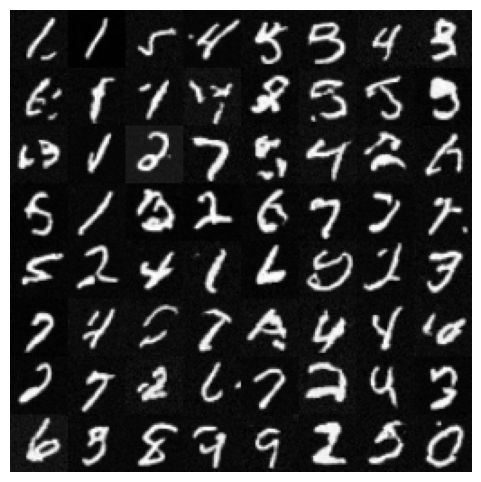

CPU times: user 4.35 s, sys: 142 ms, total: 4.49 s
Wall time: 4.22 s


In [112]:
%%time
eta = 0
tau = 10

processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta, tau = tau, scheduling = 'uniform')
x_DDIM_10X = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM_10X, sampling_number)

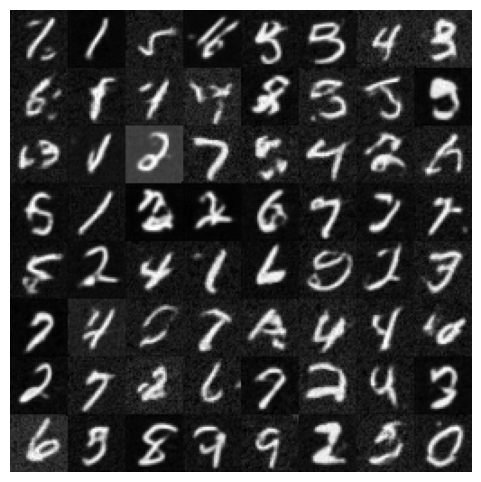

CPU times: user 748 ms, sys: 147 ms, total: 895 ms
Wall time: 625 ms


In [113]:
%%time
eta = 0
tau = 100

processDDIM = DiffusionProcessDDIM(beta_1, beta_T, T, model, device, shape, eta, tau = tau, scheduling = 'uniform') # DDPM
x_DDIM_100X = processDDIM.sampling(sampling_number, sample = z_first, only_final = only_final)
imshow(x_DDIM_100X, sampling_number)